In [1]:
%matplotlib inline
from IPython import display
from matplotlib import pyplot as plt
from mxnet import autograd,nd
import random

In [2]:
# 3.2.1生成数据集
num_inputs= 2
num_examples= 1000
true_w = [2,-3.4]
true_b = 4.2
features = nd.random.normal(scale=1,shape=(num_examples,num_inputs))
#features[:,0]截取所有行，0列的元素，获得一个一维行向量,即1x1000
labels = true_w[0] *features[:,0]+true_w[1] * features[:,1]+true_b 
labels +=nd.random.normal(scale=0.01,shape=labels.shape)
features.shape,labels.shape#features为1000x2,labels为1x1000

((1000, 2), (1000,))

In [3]:
features[0],labels[0]

(
 [1.1630785 0.4838046]
 <NDArray 2 @cpu(0)>,
 
 [4.879625]
 <NDArray 1 @cpu(0)>)

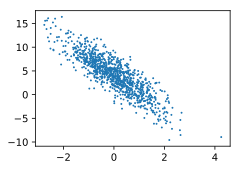

In [4]:
def use_svg_display():
    # 用矢量图显示
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5,2.5)):
    use_svg_display()
    # 设置图的尺寸
    plt.rcParams['figure.figsize'] =figsize
    
set_figsize()
plt.scatter(features[:,1].asnumpy() , labels.asnumpy(),1);# 加分号只显示图

In [21]:
display.set_matplotlib_formats??

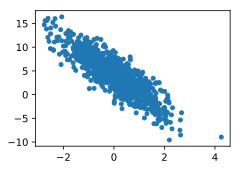

In [5]:
# plt作图函数以及use_svg_display函数和set_figsize函数定义在d2lzh包⾥
import d2lzh as d2l
# 调⽤d2lzh.set_figsize()即可打印⽮量图并设置图的尺⼨为（5，5），默认尺寸为（3.5，2.5） 
d2l.set_figsize((3.5,2.5))
# 'o'为以点的方式连接,marksize为散点的大小
d2l.plt.plot(features[:,1].asnumpy() , labels.asnumpy(),'o',markersize=4);# 加分号只显示图

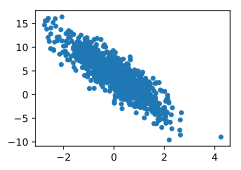

In [6]:
import d2lzh as d2l
d2l.set_figsize((3.5,2.5))
# scatter默认以'o'方式画图，s为散点的大小，s==marksize**2，即marksize=4与s=16的散点大小相同
d2l.plt.scatter(features[:,1].asnumpy() , labels.asnumpy(),s=16);# 加分号只显示图

In [7]:
# help(d2l.plt.plot)

In [8]:
# 3.2.2读取数据
# 本函数已保存在d2lzh包中⽅便以后使⽤
# 此函数每次返回batch_size（批量⼤小）个随机样本的特征和标签 
def data_iter(batch_size, features, labels):
    num_examples =len(features)
    indices =list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        # j代表从indices中按照batch_size大小提取的一系列随机排列的索引值
        # min函数保证当样本不能被批量大小整除时，可以返回最后一批次的样本
        j=nd.array(indices[i:min(i + batch_size,num_examples)])
        # take函数根据索引值j获得features和labels中的batch_size数量样本的数据集并返回对应元素
        yield features.take(j),labels.take(j) 

In [9]:
batch_size =10
for X,y in data_iter(batch_size,features,labels):
    print(X,y)
    break


[[-0.61562574  1.1182039 ]
 [-0.8062988  -1.1381161 ]
 [-0.20937306  1.058954  ]
 [-0.8512015  -1.286459  ]
 [-0.04956551  2.0028913 ]
 [ 0.18291481 -0.71730757]
 [ 1.2182702   0.7591572 ]
 [ 1.7690846   0.52072245]
 [-0.8226897  -1.4554818 ]
 [ 0.15364595  1.0113305 ]]
<NDArray 10x2 @cpu(0)> 
[-0.8371655   6.457418    0.17203434  6.8749576  -2.7054806   7.005437
  4.063668    5.9596443   7.5165896   1.0660378 ]
<NDArray 10 @cpu(0)>


In [10]:
# 3.2.3初始化模型参数
w = nd.random.normal(scale=0.01,shape=(num_inputs,1))
b = nd.zeros(shape=(1,))
w,b

(
 [[ 0.01464221]
  [-0.01305814]]
 <NDArray 2x1 @cpu(0)>,
 
 [0.]
 <NDArray 1 @cpu(0)>)

In [11]:
# 对这些参数求梯度来迭代参数的值，因此我们需要创建它们的梯度
w.attach_grad()
b.attach_grad()

In [12]:
# 3.2.4定义模型
# 本函数已保存在d2lzh包中⽅便以后使⽤ 
def linreg(X,w,b):# X为 10x2，w为2x1
    return nd.dot(X,w)+b#return 10x1

In [13]:
# 3.2.5定义损失函数
# 本函数已保存在d2lzh包中⽅便以后使⽤ 
# 模型预测值y_hat,真实值y
def squared_loss(y_hat,y):#y_hat为10x1，y为1x10
    return (y_hat-y.reshape(y_hat.shape))**2/2

In [14]:
# 3.2.6定义优化算法
# 本函数已保存在d2lzh包中⽅便以后使⽤ 
# sgd函数实现了小批量随机梯度下降算法
# lr为学习率，batch_size为批量大小\B\,(lr/\B\)*param.grad为模型参数在本次迭代的减小量
def sgd(params,lr,batch_size):
    for param in params:
        param[:] =param -lr *param.grad /batch_size

In [15]:
# 3.2.7训练模型
#学习率和迭代周期个数均为超参数
lr =0.03 # 学习率
num_epochs = 3 #迭代周期个数
net = linreg #模型,为预测值
loss =squared_loss #损失函数

for epoch in range(1,num_epochs+1):# 训练模型⼀共需要num_epochs个迭代周期 
    # 在每⼀个迭代周期中，会使⽤训练数据集中所有样本⼀次（假设样本数能够被批量⼤⼩整除）。
    # X和y分别是⼩批量样本的特征和标签,data_iter为每次返回batch_size大小的数据集
    train_l ,n=0.0,0
    for X,y in data_iter(batch_size,features,labels):
        with autograd.record():
            l = loss(net(X,w,b),y).sum()# l是⼩批量样本关于X和y的loss 
        l.backward() # 对⼩批量样本的损失l求关于模型参数w,b的梯度
        sgd([w,b],lr,batch_size) # 使⽤⼩批量随机梯度下降(sgd)算法迭代模型参数
        train_l +=l.asscalar()
        n+=y.size
    #train_l = loss(net(features, w, b), labels) #一个迭代周期中使用所有样本求得模型参数w，b后的所有样本的loss
    #print(train_l.mean().asnumpy())
    print('epoch %d,loss %f' %(epoch,train_l/n))#mean()求所有数的平均值，并返回只有一个元素NDArray

epoch 1,loss 2.797884
epoch 2,loss 0.005998
epoch 3,loss 0.000061


In [16]:
true_w,w,true_b,b

([2, -3.4],
 
 [[ 1.9999676]
  [-3.3998518]]
 <NDArray 2x1 @cpu(0)>,
 4.2,
 
 [4.199982]
 <NDArray 1 @cpu(0)>)

In [17]:
# 练习1.为什么squared_loss函数中需要使⽤reshape函数？
# 答：模型预测值y_hat为10x1，真实值y为1x10,故对y用reshape为10x1
    for X,y in data_iter(batch_size,features,labels):
        #with autograd.record():
            #l = loss(net(X,w,b),y)
        print(net(X,w,b),y)
        break


[[ 0.51782656]
 [-0.21122456]
 [ 4.5010085 ]
 [ 1.3525712 ]
 [ 3.6322093 ]
 [ 5.1785355 ]
 [-1.6085691 ]
 [ 7.090302  ]
 [ 5.0652966 ]
 [ 1.6932628 ]]
<NDArray 10x1 @cpu(0)> 
[ 0.52966595 -0.2063397   4.498421    1.3465699   3.6316695   5.175732
 -1.6048086   7.0896244   5.0759344   1.6905847 ]
<NDArray 10 @cpu(0)>


In [18]:
# 练习2.尝试使⽤不同的学习率，观察损失函数值的下降快慢
# 学习率小时，损失函数下降较快，当在相同迭代次数下，损失函数值较大
# lr=0.01时
# epoch 1,loss 2.186219
# epoch 2,loss 0.287401
# epoch 3,loss 0.038027
# lr=0.03时
# epoch 1,loss 0.035091
# epoch 2,loss 0.000121
# epoch 3,loss 0.000049
# lr=0.05时
# epoch 1,loss 0.000049
# epoch 2,loss 0.000048
# epoch 3,loss 0.000049

In [19]:
# 练习3.如果样本个数不能被批量⼤小整除，data_iter函数的⾏为会有什么变化？
# 答：当样本个数不能被批量⼤小整除时，min函数保证可以返回最后一批次的样本
#    但是由于batch_size仍为原值(偏大,η/|B|偏小，θ ← θ − （η/|B|）* ∑（ℓ^(i)(θ).grad）)，
#    导致最后一批次的样本的模型参数在sgd梯度下降函数中迭代后的模型参数θ偏大
# 3.2.1生成数据集
num_inputs= 2
num_examples= 19
true_w = [2,-3.4]
true_b = 4.2
features = nd.random.normal(scale=1,shape=(num_examples,num_inputs))
labels = true_w[0] *features[:,0]+true_w[1] * features[:,1]+true_b 
labels +=nd.random.normal(scale=0.01,shape=labels.shape)
features.shape,labels.shape
batch_size =10
for X,y in data_iter(batch_size,features,labels):
    print(X,y)



[[ 1.6106696  -1.2642231 ]
 [ 0.10874183  0.5353433 ]
 [-0.19518924 -2.79099   ]
 [-1.0055363   3.1322145 ]
 [ 0.64281946  1.6597843 ]
 [ 2.0036721  -0.50719374]
 [ 1.4371866  -0.31814137]
 [-1.8610498  -0.46895596]
 [ 0.93444026  0.5380863 ]
 [-0.3572044  -1.4980611 ]]
<NDArray 10x2 @cpu(0)> 
[11.707301   2.6049001 13.318679  -8.4578905 -0.1674852  9.920728
  8.159256   2.056002   4.2420335  8.572568 ]
<NDArray 10 @cpu(0)>

[[-0.43589905 -0.49295083]
 [-0.6768301  -0.61593443]
 [ 0.21444707  0.99384654]
 [-0.16038011  0.84187603]
 [ 0.78839695  0.56459594]
 [ 0.13895428  0.66711557]
 [-0.16282491  0.6836102 ]
 [-0.01003419 -1.086754  ]
 [-1.3096325  -0.14141555]]
<NDArray 9x2 @cpu(0)> 
[5.000095  4.9424906 1.262608  1.0021131 3.8749669 2.2184157 1.5472374
 7.881015  2.0650945]
<NDArray 9 @cpu(0)>
